In [1]:
import importlib 
import utils
import os
import json
import pandas as pd
importlib.reload(utils)

<module 'utils' from '/home/miaoran/FaithBench/assign/utils.py'>

In [2]:
# from batch ID to the corresponding sample IDs
skip_samples = {
    5: range(40, 50), 
    10: range(10,20),
    11: range(10),
    12: range(20, 30), 
    15: range(40, 50)
}

annotator_list = {
    7: ['yujia', 'manveer'],
    8: ['miaoran', 'chenyu'],
    # 11: ['rogger', 'matt'] #'yujia',
}

three_annotators = [2,3,4,5,10,11]

exclude_batch = [11,13,16]

halu_labels_list = [['Unwanted'], ['Unwanted', 'Questionable'], ['Unwanted', 'Questionable', 'Benign']]

In [3]:
result_path = 'batch_5_src_no_sports/results'
result_files = []
skip_sample_ids = {}
selected_annotators = {}
num_annotators = {}

for batch_id in range(1,16+1):
    if batch_id in exclude_batch:
        continue
    file_name = os.path.join(result_path, f"batch_{batch_id}_annotation.json")
    result_files.append(file_name)
    if batch_id in skip_samples:
        skip_sample_ids[file_name] = skip_samples[batch_id]
    if batch_id in annotator_list:
        selected_annotators[file_name] = annotator_list[batch_id]
    if batch_id in three_annotators:
        num_annotators[file_name] = 3
    else:
        num_annotators[file_name] = 2
 
for halu_labels in halu_labels_list:
    # Get three variables
    # halu_eval-U: evaluator with ['Unwanted'] as hallucination labels
    # halu_eval-UQ: evaluator with ['Unwanted', 'Questionable'] as hallucination labels
    # halu_eval-UQB: evaluator with ['Unwanted', 'Questionable', 'Benign'] as hallucination labels
    globals()["halu_eval-" + ''.join([label[0] for label in halu_labels])]= utils.HaluEvaluator(result_files, halu_labels=halu_labels, skip_sample_ids=skip_sample_ids, selected_annotators=selected_annotators, num_annotators=num_annotators)
    locals()["halu_eval-" + ''.join([label[0] for label in halu_labels])].process_results()
   

## Hallucination Ranking Table

In [4]:
# Get halu rate
halu_rate_results = {}
for halu_labels in halu_labels_list:
    halu_result = locals()["halu_eval-" + ''.join([label[0] for label in halu_labels])].compute_halu_rate()
    for model, rate in halu_result.items():
        if model not in halu_rate_results:
            halu_rate_results[model] = []
        halu_rate_results[model].append(rate)
halu_rate_results_df = pd.DataFrame.from_dict(halu_rate_results, orient='index', columns=['+'.join([label[0] for label in halu_labels]) for halu_labels in halu_labels_list])

# Get ranking df
df_ranked = halu_rate_results_df.copy()
## Apply ranking for each column in reverse order
for column in df_ranked.columns:
    df_ranked[column] = df_ranked[column].astype(float).rank(ascending=True, method='min').astype(int)

# Combine original scores with ranks in the desired format
df_combined = halu_rate_results_df.applymap(str) + "/" + df_ranked.applymap(str)
model_orders = ['GPT-4o', 'GPT-3.5-Turbo', 'Llama-3.1-70B', 'Gemini-1.5-Flash', 'Llama-3.1-8B', 
                'Claude-3.5-Sonnet', 'Qwen2.5-7B', 'Phi-3-mini', 'Command-R', 'Mistral-7B']

# Sorting the DataFrame based on the given model list
df_sorted = df_combined.loc[model_orders]
df_sorted['HHEM Ldbd'] = list(range(1, 11))

# Display or further process the sorted DataFrame
print(df_sorted.to_latex())


\begin{tabular}{llllr}
\toprule
 & U & U+Q & U+Q+B & HHEM Ldbd \\
\midrule
GPT-4o & 39.34/1 & 52.46/1 & 65.57/2 & 1 \\
GPT-3.5-Turbo & 44.26/2 & 54.1/2 & 62.3/1 & 2 \\
Llama-3.1-70B & 47.54/3 & 55.74/3 & 67.21/4 & 3 \\
Gemini-1.5-Flash & 52.46/5 & 59.02/4 & 65.57/2 & 4 \\
Llama-3.1-8B & 54.1/6 & 70.49/6 & 80.33/6 & 5 \\
Claude-3.5-Sonnet & 49.18/4 & 62.3/5 & 83.61/7 & 6 \\
Qwen2.5-7B & 70.49/9 & 75.41/8 & 83.61/7 & 7 \\
Phi-3-mini & 63.93/7 & 73.77/7 & 78.69/5 & 8 \\
Command-R & 72.13/10 & 83.61/10 & 93.44/10 & 9 \\
Mistral-7B & 68.85/8 & 78.69/9 & 85.25/9 & 10 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_49148/4228287721.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_combined = halu_rate_results_df.applymap(str) + "/" + df_ranked.applymap(str)


## Annotation-level disttribution of annotation labels for the three hallucination labels only

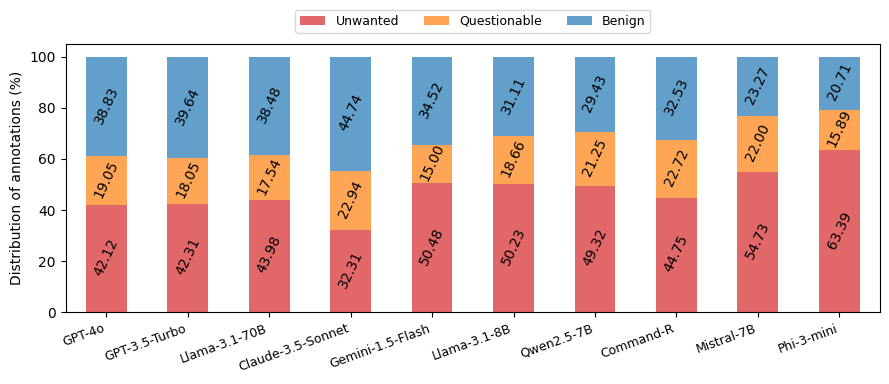

In [5]:
halu_eval = locals()["halu_eval-U"] # If you want use ['Unwanted', 'Questionable']/['Unwanted', 'Questionable','Benign'] as halu_labels, just replace -U with -UQ / -UQB
halu_eval.get_annotation_dist()

## Sample-level final label desitribuiton

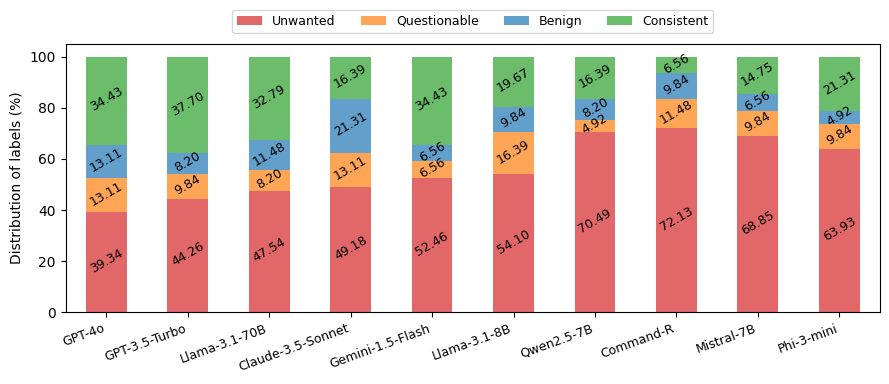

In [6]:
halu_eval.get_sample_dist()

## Hallucination rates vs. passage length

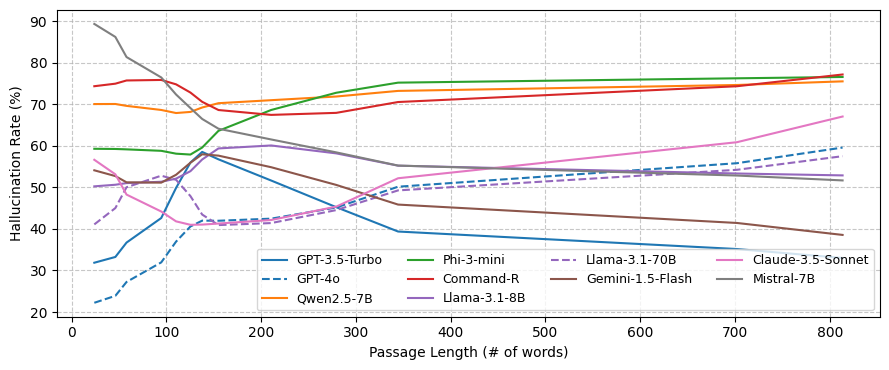

In [7]:
halu_eval.halu_vs_length('source')

## Hallucination rates vs. summary length

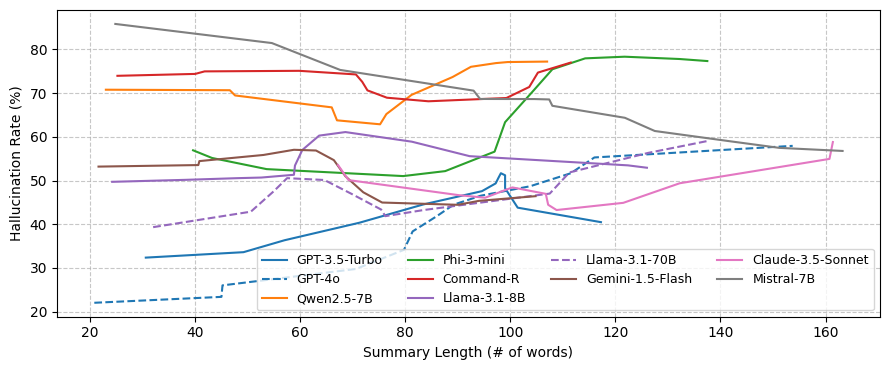

In [8]:
halu_eval.halu_vs_length('summary')

## avg. annotation count vs. passage length 
avg. annotation count: for each sample, number of a label / number of annotators

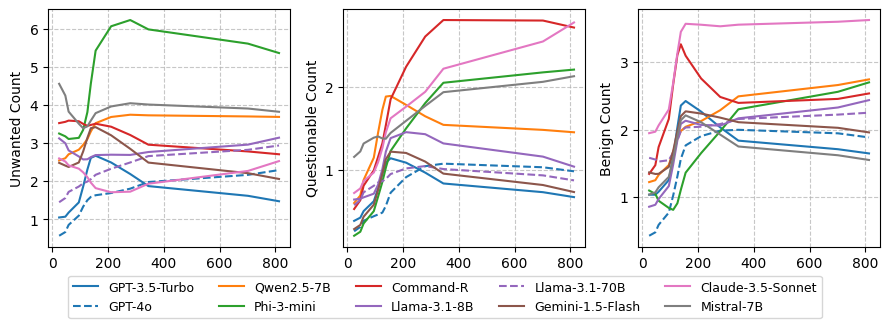

In [9]:
halu_eval.label_vs_length(mode = 'count', length_of='source')

## annotation ratio vs. passage length

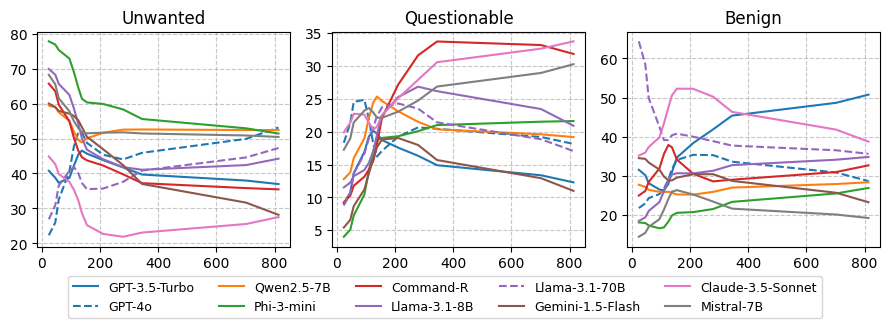

In [10]:
halu_eval.label_vs_length(mode = 'ratio', length_of='source')